# Neural Network - Code

In diesem Notebook schauen wir uns das `Fully-Connected Neural Network` Modell am MNIST Datensatz an.
Wir verwenden dazu `tensorflow`, die Deep Learning Python Library von Google.

## Setup

Setup Code muss *nicht* verstanden werden.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from tensorflow.keras.regularizers import L2
from tensorflow.keras import layers, activations, Sequential, losses


In [2]:
def plot_images(data, nrows=18, ncols=18):
    """
    Plot images with or without original data.
    :param data: Data to plot
    :param nrows: number of rows
    :param ncols: number of columns
    """
    data = data.reshape(data.shape[0], 8, 8)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    for ax, image in zip(axes.flatten(), data):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')

In [3]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [4]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    """
        Takes true and predicted labels (arrays) as input. Based on this, calculates and plots a confusion matrix.
    """
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
        display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

## Datensatz - MNIST

MNIST Daten sind Schwarz-Weiss Bilder von den Zahlen von 0 bis 9.
Es sind insgesamt 1797 Bilder mit 8 * 8 Pixel (`X_data`). Zu jedem Bild haben wir ein Label, welche Zahl auf dem Bild abgebildet ist (`y_data`).

In [5]:
data = load_digits()  # Load MNIST data set
X_data, y_data = data.images, data.target

print(X_data.shape)
print(y_data.shape)

(1797, 8, 8)
(1797,)


Wir visualisieren hier ein paar MNIST-Bilder, um einen Eindruck der Daten zu erhalten.

MNIST examples from dataset


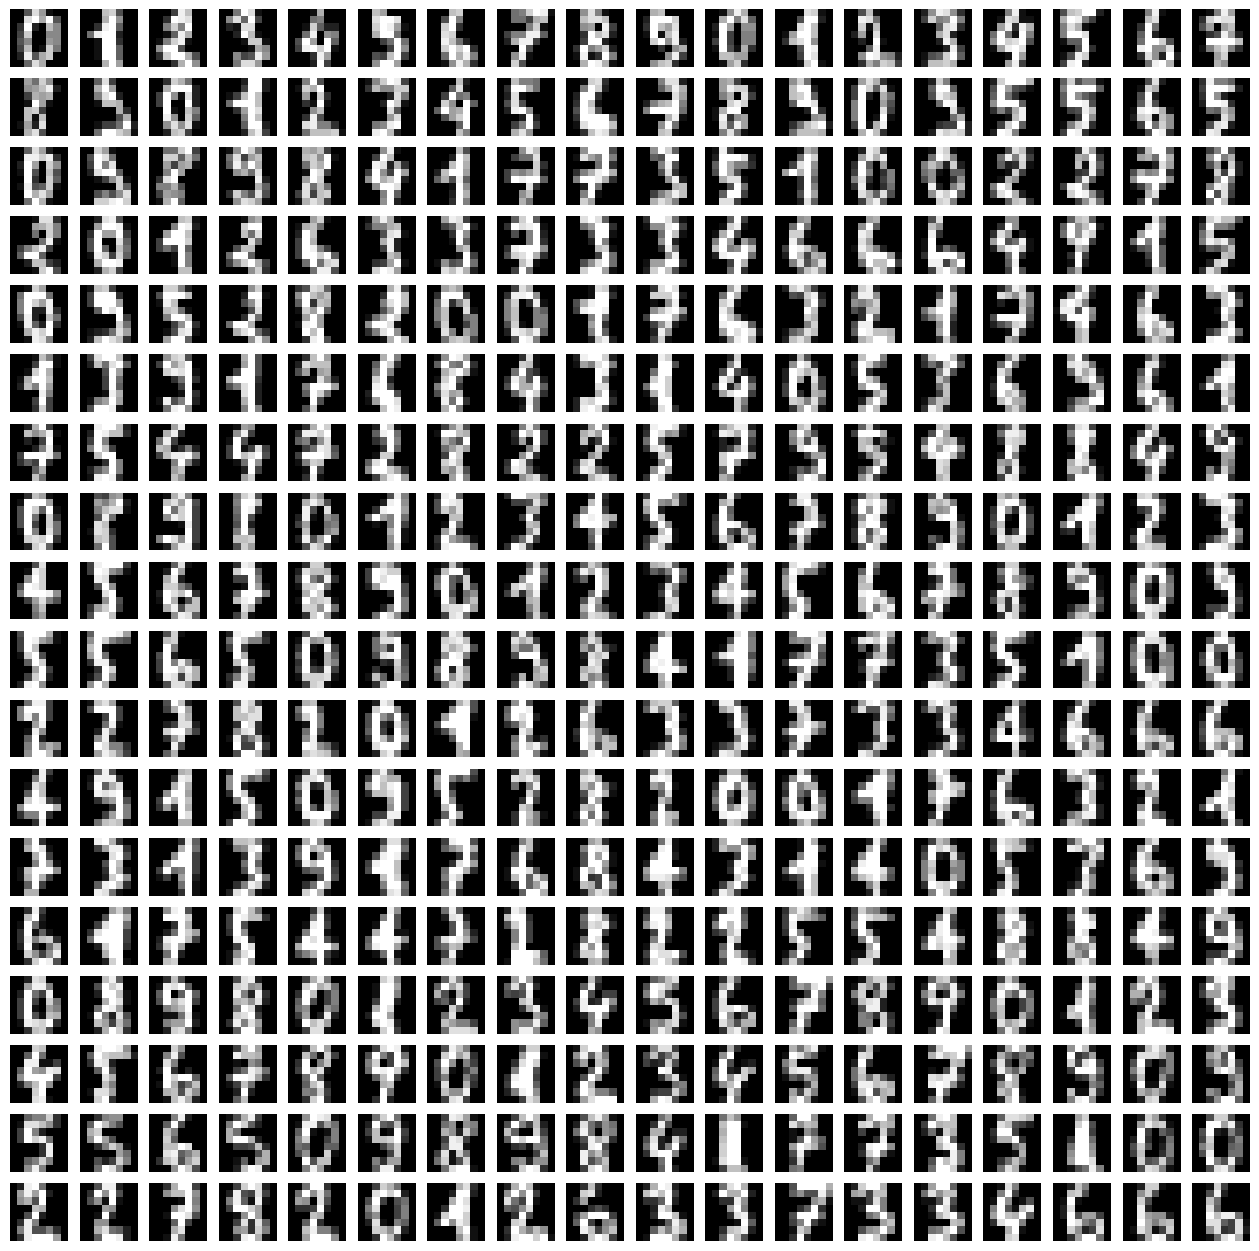

In [6]:
print("MNIST examples from dataset")
plot_images(X_data)
plt.show()

## Neural Network

Nun trainieren wir ein Neurales Netzwerk auf diesen Daten.

Als erstes teilen wir die Daten in `Train Set` und `Validation Set` auf.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

Das hier verwendete Neurale Netzwerk hat 4 Layers:
* Einen Input Layer
* Zwei Hidden Layers
* Einen Output Layer

Der Input Layer ist ein 8 Pixel mal 8 Pixel Bild bzw. 2D-Array. Als erstes `Reshapen` wir diesen 2D-Array mit 8 mal 8 Dimensionen zu einem 1D-Array mit 64 Dimensionen, weil das Feedforward Neural Network erwartet die Inputs als 1D-Array.
Dann kommt das eigentliche Netzwerk.
Der Input Layer ist dieser 1D-Array mit 64 Neuronen.
Dann kommt ein Hidden Layer (`hidden_layer_1`) mit 128 Neuronen.
Dann kommt ein Hidden Layer (`hidden_layer_2`) mit 64 Neuronen.
Dann kommt der Output Layer (`output_layer`) mit 10 Neuronen (weil wir 10 Klassen haben).
Die Hidden Layers haben alle die Aktivierungsfunktion `ReLU`.
Der Output Layer hat die Aktivierungsfunktion `softmax` (hier `linear` mit  `losses.SparseCategoricalCrossentropy(from_logits=True)` als Kostenfunktion, was indirekt dem Softmax entspricht).
Das Neurale Netzwerk wird mit Batch Gradient Descent (`sgd`) trainiert und nach der Maximum Liklihood Kostenfunktion optimiert (`SparseCategoricalCrossentropy`). Zudem wollen wir die Performanz vom Modell mit der Kostenfunktion `accuracy` messen.

`nn.summary()` gibt uns Informationen zur Architektur vom Netzwerk. Wir finden unsere Layers wieder und sehen wie viele Parameter (Verbindungen) pro Layer tatsächlich vorhanden sind.

In [8]:
nn = Sequential([
    layers.InputLayer(input_shape=(8,8), name='input_layer'),
    layers.Reshape(target_shape=(8*8,), name= 'reshape_layer'),
    layers.Dense(128, activation=activations.relu, kernel_regularizer=L2(0.01),  name='hidden_layer_1', ),
    layers.Dense(64, activation=activations.relu, kernel_regularizer=L2(0.01),  name='hidden_layer_2', ),
    layers.Dense(10, activation=activations.linear, kernel_regularizer=L2(0.01), name='output_layer'),
])
nn.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_layer (Reshape)     (None, 64)                0         
                                                                 
 hidden_layer_1 (Dense)      (None, 128)               8320      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 17,226
Trainable params: 17,226
Non-trainable params: 0
_________________________________________________________________
None


Bis jetzt haben wir nur das Netzwerk aufgebaut.

Nun fitten wir es noch mit den Daten. Dazu müssen wir die `batch_size` für Batch Gradient Descent angeben und wie oft es über die gesamten Daten iterieren soll (`epochs`).
Zudem geben wir hier die Validation Daten an. Dann reportet und Tensorflow während dem Training die Performanz auf dem `Validation Set`.
Nach dem Training visualisieren wir die `Learning Curve`, die uns zeigt, wie sich die `accuracy` vom Netzwerk über die Epochen entwickelt.

In [9]:
history = nn.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200


2023-05-01 13:27:52.499840: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 0s 10ms/step - loss: 5.2681 - accuracy: 0.2903 - val_loss: 3.0254 - val_accuracy: 0.6444
Epoch 2/200
11/11 [==============================] - 0s 2ms/step - loss: 2.7936 - accuracy: 0.7127 - val_loss: 2.6236 - val_accuracy: 0.7422
Epoch 3/200
11/11 [==============================] - 0s 2ms/step - loss: 2.4508 - accuracy: 0.8337 - val_loss: 2.3403 - val_accuracy: 0.8422
Epoch 4/200
11/11 [==============================] - 0s 2ms/step - loss: 2.2948 - accuracy: 0.8857 - val_loss: 2.2386 - val_accuracy: 0.8889
Epoch 5/200
11/11 [==============================] - 0s 2ms/step - loss: 2.2010 - accuracy: 0.9154 - val_loss: 2.1559 - val_accuracy: 0.9067
Epoch 6/200
11/11 [==============================] - 0s 2ms/step - loss: 2.1358 - accuracy: 0.9295 - val_loss: 2.1095 - val_accuracy: 0.9222
Epoch 7/200
11/11 [==============================] - 0s 2ms/step - loss: 2.0921 - accuracy: 0.9347 - val_loss: 2.0662 - val_accuracy: 0.9333
Epoch 8/200
11/11 [=====

Epoch 59/200
11/11 [==============================] - 0s 2ms/step - loss: 1.5434 - accuracy: 0.9963 - val_loss: 1.5773 - val_accuracy: 0.9800
Epoch 60/200
11/11 [==============================] - 0s 2ms/step - loss: 1.5367 - accuracy: 0.9978 - val_loss: 1.5720 - val_accuracy: 0.9733
Epoch 61/200
11/11 [==============================] - 0s 2ms/step - loss: 1.5305 - accuracy: 0.9978 - val_loss: 1.5651 - val_accuracy: 0.9800
Epoch 62/200
11/11 [==============================] - 0s 2ms/step - loss: 1.5247 - accuracy: 0.9970 - val_loss: 1.5607 - val_accuracy: 0.9778
Epoch 63/200
11/11 [==============================] - 0s 2ms/step - loss: 1.5184 - accuracy: 0.9970 - val_loss: 1.5535 - val_accuracy: 0.9800
Epoch 64/200
11/11 [==============================] - 0s 2ms/step - loss: 1.5129 - accuracy: 0.9955 - val_loss: 1.5472 - val_accuracy: 0.9800
Epoch 65/200
11/11 [==============================] - 0s 2ms/step - loss: 1.5061 - accuracy: 0.9963 - val_loss: 1.5413 - val_accuracy: 0.9756
Epoch 

11/11 [==============================] - 0s 2ms/step - loss: 1.2342 - accuracy: 0.9985 - val_loss: 1.2741 - val_accuracy: 0.9822
Epoch 117/200
11/11 [==============================] - 0s 2ms/step - loss: 1.2294 - accuracy: 0.9978 - val_loss: 1.2694 - val_accuracy: 0.9844
Epoch 118/200
11/11 [==============================] - 0s 2ms/step - loss: 1.2252 - accuracy: 0.9978 - val_loss: 1.2634 - val_accuracy: 0.9800
Epoch 119/200
11/11 [==============================] - 0s 2ms/step - loss: 1.2206 - accuracy: 0.9978 - val_loss: 1.2601 - val_accuracy: 0.9800
Epoch 120/200
11/11 [==============================] - 0s 2ms/step - loss: 1.2161 - accuracy: 0.9978 - val_loss: 1.2540 - val_accuracy: 0.9822
Epoch 121/200
11/11 [==============================] - 0s 2ms/step - loss: 1.2111 - accuracy: 0.9978 - val_loss: 1.2503 - val_accuracy: 0.9822
Epoch 122/200
11/11 [==============================] - 0s 2ms/step - loss: 1.2067 - accuracy: 0.9970 - val_loss: 1.2452 - val_accuracy: 0.9822
Epoch 123/200

11/11 [==============================] - 0s 2ms/step - loss: 1.0018 - accuracy: 0.9978 - val_loss: 1.0418 - val_accuracy: 0.9822
Epoch 174/200
11/11 [==============================] - 0s 2ms/step - loss: 0.9989 - accuracy: 0.9978 - val_loss: 1.0374 - val_accuracy: 0.9822
Epoch 175/200
11/11 [==============================] - 0s 2ms/step - loss: 0.9952 - accuracy: 0.9978 - val_loss: 1.0333 - val_accuracy: 0.9822
Epoch 176/200
11/11 [==============================] - 0s 2ms/step - loss: 0.9913 - accuracy: 0.9985 - val_loss: 1.0297 - val_accuracy: 0.9822
Epoch 177/200
11/11 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.9978 - val_loss: 1.0262 - val_accuracy: 0.9800
Epoch 178/200
11/11 [==============================] - 0s 2ms/step - loss: 0.9844 - accuracy: 0.9978 - val_loss: 1.0258 - val_accuracy: 0.9822
Epoch 179/200
11/11 [==============================] - 0s 2ms/step - loss: 0.9809 - accuracy: 0.9985 - val_loss: 1.0193 - val_accuracy: 0.9822
Epoch 180/200

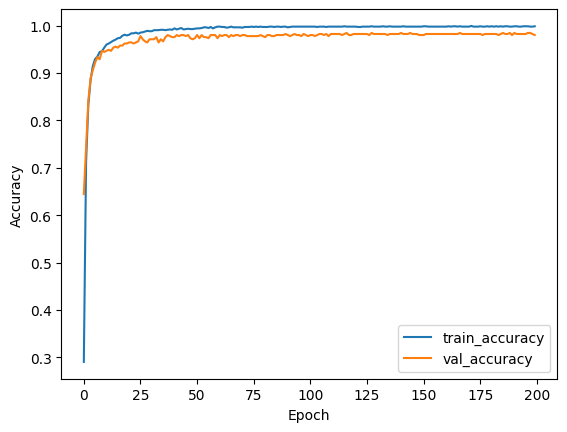

15/15 [==============================] - 0s 430us/step
0.98


In [10]:
plot_history(history)

y_val_hat_prob = nn.predict(X_val)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val))